In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Let's see if training a model without any burnables yields better results.

In [2]:
!pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.2/812.2 kB 24.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manyl

In [3]:
import torch
import torchvision
from torchvision import datasets, transforms
import torchmetrics
import lightning as L
import numpy as np
import matplotlib.pyplot as plt
import os
import collections
import pandas as pd
import seaborn as sns

In [4]:
mean = np.array([0.6760, 0.6308, 0.5746])
std = np.array([0.2055, 0.2108, 0.2250])

In [5]:
data_dir = 'drive/MyDrive/garbage'
sets = ['TRAIN', 'TEST']

In [6]:
data_transforms = {
    'TRAIN':transforms.Compose([
        transforms.Resize(size=(150, 300)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ]),
    'TEST':transforms.Compose([
        transforms.Resize(size=(150, 300)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])
}

In [7]:
# class FilteredImageFolder(datasets.ImageFolder):
#     def __init__(self, root, exclude_folder=None, transform=None):
#         self.exclude_folder = exclude_folder
#         super(FilteredImageFolder, self).__init__(root, transform=transform)

#         if exclude_folder:
#             self.samples = [s for s in self.samples if exclude_folder not in s[0]]
#             self.targets = [s[1] for s in self.samples]

In [7]:
class FilteredImageFolder(datasets.ImageFolder):
    def __init__(self, root, exclude_folder=None, transform=None):
        self.exclude_folder = exclude_folder
        # Filter out the excluded folder before initializing the parent class
        all_classes, class_to_idx = self.find_classes(root)
        if exclude_folder and exclude_folder in class_to_idx:
            del class_to_idx[exclude_folder]
            all_classes.remove(exclude_folder)
        self.filtered_classes = all_classes
        self.filtered_class_to_idx = class_to_idx
        super(FilteredImageFolder, self).__init__(root, transform=transform)
        # Re-filter samples after the parent initialization to match updated class_to_idx
        if exclude_folder:
            self.samples = [s for s in self.samples if exclude_folder not in s[0]]
            self.targets = [self.filtered_class_to_idx[self.classes[s[1]]] for s in self.samples]
            self.classes = self.filtered_classes
            self.class_to_idx = self.filtered_class_to_idx

    def find_classes(self, directory):
        """Finds the class folders in a dataset.

        Args:
            directory (string): Root directory path.

        Returns:
            tuple: (classes, class_to_idx) where classes are relative to (directory), and class_to_idx is a dictionary.
        """
        classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir() and entry.name !="burnable")
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx


In [8]:
dataset = FilteredImageFolder(os.path.join(data_dir, sets[0]), exclude_folder='burnable', transform=data_transforms['TRAIN'])
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1], generator=generator)
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))


19071
2384
2383


In [13]:
dataset.class_to_idx

{'PET': 0,
 'books_and_paper': 1,
 'cans': 2,
 'cardboard': 3,
 'clothes': 4,
 'danger': 5,
 'glass_bin': 6,
 'metal': 7,
 'nonburn': 8,
 'plastic': 9}

In [14]:
train_set_targets = torch.tensor([dataset.targets[i] for i in train_dataset.indices])
train_set_targets.shape

torch.Size([19071])

In [15]:
from collections import Counter
train_targets_list = train_set_targets.tolist()
class_counts = Counter(train_targets_list)
class_counts_dict = dict(class_counts)
class_counts_dict

{1: 2245,
 6: 1983,
 4: 4263,
 2: 1399,
 8: 3154,
 9: 1543,
 5: 759,
 0: 1171,
 7: 995,
 3: 1559}

In [16]:
class_idx_dict = dataset.class_to_idx
class_idx_dict

{'PET': 0,
 'books_and_paper': 1,
 'cans': 2,
 'cardboard': 3,
 'clothes': 4,
 'danger': 5,
 'glass_bin': 6,
 'metal': 7,
 'nonburn': 8,
 'plastic': 9}

In [17]:
for i, key in enumerate(class_idx_dict.keys(), start=0):
  class_idx_dict[key] = class_counts_dict[i]
class_idx_dict

{'PET': 1171,
 'books_and_paper': 2245,
 'cans': 1399,
 'cardboard': 1559,
 'clothes': 4263,
 'danger': 759,
 'glass_bin': 1983,
 'metal': 995,
 'nonburn': 3154,
 'plastic': 1543}

Text(0.5, 1.0, 'Train Dataset Class Distribution')

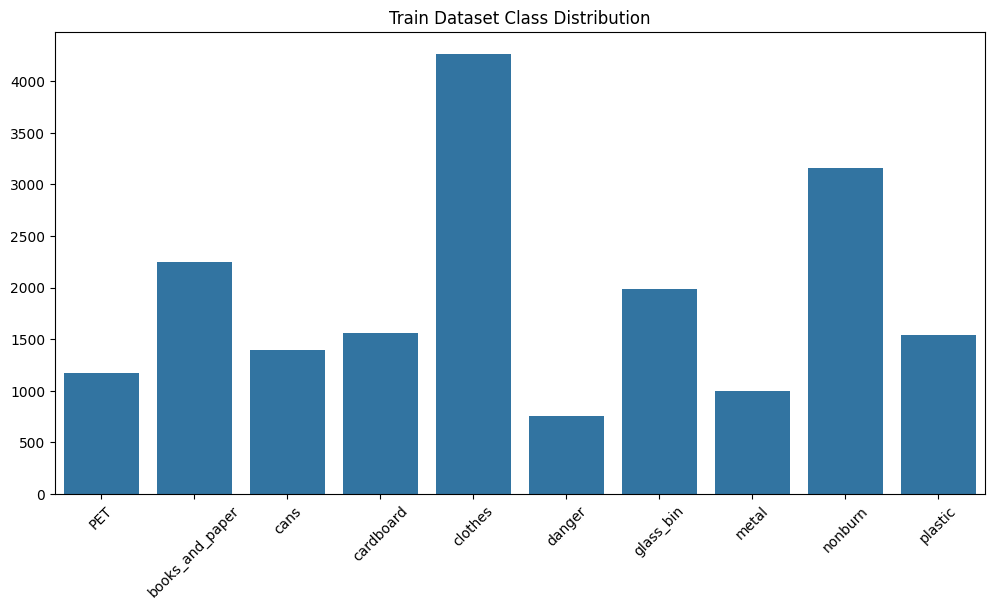

In [18]:
plt.figure(figsize=(12,6))
sns.barplot(class_idx_dict)
plt.xticks(rotation=45)
plt.title('Train Dataset Class Distribution')

In [19]:
for key, value in class_idx_dict.items():
    print(f'Training Dataset is {round(value/len(train_dataset)*100,2)}% {key}')

Training Dataset is 6.14% PET
Training Dataset is 11.77% books_and_paper
Training Dataset is 7.34% cans
Training Dataset is 8.17% cardboard
Training Dataset is 22.35% clothes
Training Dataset is 3.98% danger
Training Dataset is 10.4% glass_bin
Training Dataset is 5.22% metal
Training Dataset is 16.54% nonburn
Training Dataset is 8.09% plastic


In [20]:
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, shuffle=True, batch_size=32, num_workers=11)
val_dataloader = torch.utils.data.DataLoader(dataset=val_dataset, shuffle=False, batch_size=32, num_workers=11)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, shuffle=False, batch_size=32, num_workers=11)

In [32]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

torch.Size([32, 3, 150, 300])
tensor([ 1,  0, 10,  3,  8,  7,  3,  7,  7,  7,  9,  8,  3,  9,  8,  6,  9,  0,
         9,  8,  5,  7,  1,  6,  9,  9,  1,  1,  5,  5,  1,  5])


Text(0.5, 1.0, 'Training Batch Image Sample')

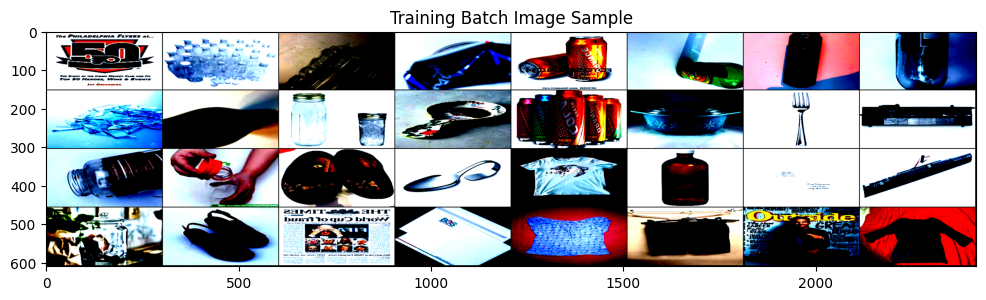

In [33]:
images, labels = next(iter(train_dataloader))
print(images.shape)
print(labels)
plt.figure(figsize=(12,6))
imshow(torchvision.utils.make_grid(images))
plt.title('Training Batch Image Sample')

In [21]:
class GarbageModel(L.LightningModule):
    def __init__(self, num_channels, num_classes):
        super().__init__()
        base_model = torchvision.models.vgg16(weights=torchvision.models.VGG16_Weights.DEFAULT)
        # check number of features input to final linear layer of model
        num_features = base_model.classifier[6].in_features
        base_model.classifier[6] = torch.nn.Linear(in_features=num_features, out_features=num_classes)
        for param in base_model.features.parameters(): # freeze all the model parameters in the features part
          param.requires_grad = False
        self.model = base_model
        self.num_classes = num_classes
        self.loss_function = torch.nn.CrossEntropyLoss()
        self.accuracy = torchmetrics.classification.MulticlassAccuracy(num_classes=num_classes)
        self.precision = torchmetrics.classification.MulticlassPrecision(num_classes=num_classes)

    def forward(self, x):
        x = self.model(x)
        return x

    def _commmon_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = self.loss_function(logits, y)
        return loss, logits, y

    def training_step(self, batch, batch_idx):
      loss, logits, y = self._commmon_step(batch, batch_idx)
      accuracy = self.accuracy(logits, y)
      precision = self.precision(logits, y)
      self.log_dict({'training_loss':loss, 'training_accuracy': accuracy, 'training_precision': precision})
      return loss

    def validation_step(self, batch, batch_idx):
      loss, logits, y = self._commmon_step(batch, batch_idx)
      accuracy = self.accuracy(logits, y)
      precision = self.precision(logits, y)
      self.log_dict({'validation_loss':loss, 'validation_accuracy': accuracy, 'validation_precision': precision})
      return loss

    def test_step(self, batch, batch_idx):
      loss, logits, y = self._commmon_step(batch, batch_idx)
      accuracy = self.accuracy(logits, y)
      precision = self.precision(logits, y)
      self.log_dict({'test_loss':loss, 'test_accuracy': accuracy, 'test_precision': precision})
      return loss

    def predict_step(self, batch, batch_idx):
      x, y = batch
      logits = self.forward(x)
      preds = torch.argmax(logits, dim=1)
      return preds

    def configure_optimizers(self):
      optimizer = torch.optim.Adam(self.parameters(), lr=0.01)
      scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.8)
      return [optimizer], [scheduler]

In [22]:
model = GarbageModel(num_channels=3, num_classes=10)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 211MB/s]


In [23]:
csv_logger = L.pytorch.loggers.CSVLogger('drive/MyDrive/garbage/noburn_logs')

In [24]:
trainer = L.Trainer(accelerator='auto', max_epochs=10, logger=csv_logger)
trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: You are using a CUDA device ('NVIDIA L4') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:lightning.pytorch.utilities.rank_zero:You are using a CUDA device ('NVIDIA L4') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more det

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [25]:
results = trainer.test(model, dataloaders=test_dataloader)
results

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.2718900144100189     │
│         test_loss         │    1.6222801208496094     │
│      test_precision       │    0.25002479553222656    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.6222801208496094,
  'test_accuracy': 0.2718900144100189,
  'test_precision': 0.25002479553222656}]

In [26]:
import pandas as pd
import seaborn as sns

In [27]:
csv_file_path = 'drive/MyDrive/garbage/logs/lightning_logs/version_0/metrics.csv'
metrics_df = pd.read_csv(csv_file_path)
metrics_df.head()

,epoch,step,test_accuracy,test_loss,test_precision,training_accuracy,training_loss,training_precision,validation_accuracy,validation_loss,validation_precision
0,0,49,NaN,NaN,NaN,0.475000,30.067581,0.366250,NaN,NaN,NaN
1,0,99,NaN,NaN,NaN,0.503968,35.986908,0.510684,NaN,NaN,NaN
2,0,149,NaN,NaN,NaN,0.251748,46.170219,0.219008,NaN,NaN,NaN
3,0,199,NaN,NaN,NaN,0.319444,128.713120,0.356111,NaN,NaN,NaN
4,0,249,NaN,NaN,NaN,0.421429,119.419434,0.415909,NaN,NaN,NaN


In [28]:
train_metrics = metrics_df[~metrics_df['training_loss'].isna()][['epoch', 'step','training_loss', 'training_accuracy', 'training_precision']]
val_metrics = metrics_df[~metrics_df['validation_loss'].isna()][['epoch','validation_loss', 'validation_accuracy', 'validation_precision']]
test_metrics = metrics_df[~metrics_df['test_loss'].isna()][['test_loss', 'test_accuracy', 'test_precision']]
train_metrics.head()

,epoch,step,training_loss,training_accuracy,training_precision
0,0,49,30.067581,0.475000,0.366250
1,0,99,35.986908,0.503968,0.510684
2,0,149,46.170219,0.251748,0.219008
3,0,199,128.713120,0.319444,0.356111
4,0,249,119.419434,0.421429,0.415909


Text(0.5, 1.0, 'Training and Validation Loss')

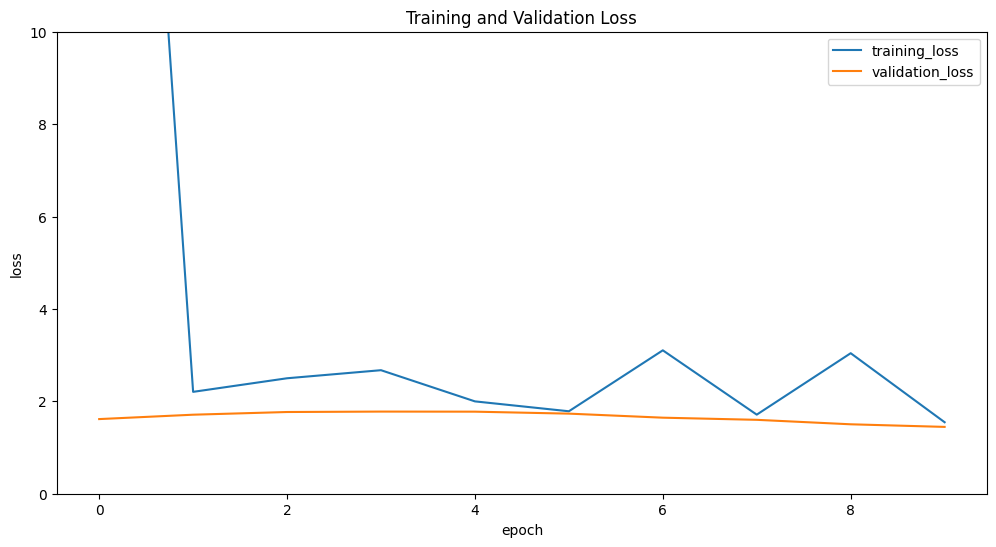

In [29]:
plt.figure(figsize=(12,6))
sns.lineplot(data=train_metrics, x='epoch', y='training_loss', label='training_loss', errorbar=None)
sns.lineplot(data=val_metrics, x='epoch',y='validation_loss', label='validation_loss')
plt.legend()
plt.ylim(0, 10)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('Training and Validation Loss')

Text(0.5, 1.0, 'Training and Validation Accuracy')

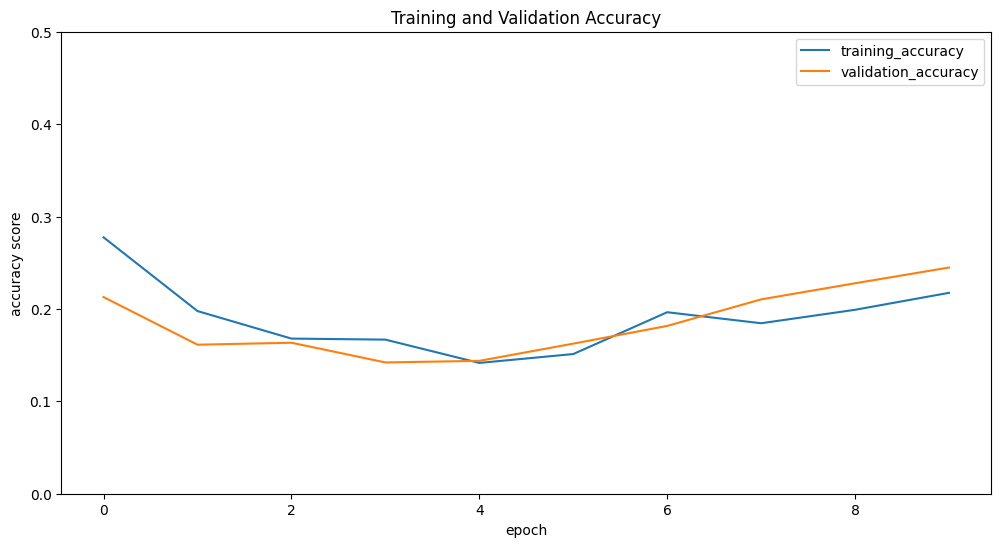

In [30]:
plt.figure(figsize=(12,6))
sns.lineplot(data=train_metrics, x='epoch', y='training_accuracy', label='training_accuracy', errorbar=None)
sns.lineplot(data=val_metrics, x='epoch',y='validation_accuracy', label='validation_accuracy')
plt.legend()
plt.ylim(0, 0.5)
plt.ylabel('accuracy score')
plt.xlabel('epoch')
plt.title('Training and Validation Accuracy')

In [31]:
from PIL import Image

In [32]:
my_tester = Image.open(os.path.join(os.getcwd(), 'drive/MyDrive/garbage/random_plastic.jpeg')).convert('RGB')

In [33]:
my_tester = data_transforms['TEST'](my_tester)
my_tester.unsqueeze_(0)
my_tester.shape

torch.Size([1, 3, 150, 300])

In [34]:
with torch.no_grad():
  pred = model(my_tester)
  _, predicted_class = torch.max(pred, 1)
  print(predicted_class)

tensor([8])
